# Develop Scoring  Model

## Define Task

In this notebook, I will build a classification model that predicts whether the client will default on the repayment of their loans or not.

I will perform an extensive EDA and then start with building a simple logistic regression. I will then perform feature engineering and feature selection in order to trim down the number of features to be used in the analysis. I will build a random forest classifier with the new features and apply RandomizedSearchCV for hyperparameter tuning.

The final aim is to see which model will perform best between the logistic regression and the random forest classifier in predicting whether the client will default or not.

#### Import core packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print('All 4 libraries are imported successfully.')

All 4 libraries are imported successfully.


#### Ignore future warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Import dataset

In [3]:
#Import the dataset
clientData = pd.read_csv('/Users/user/Desktop/Risk/application_train.csv')

#Display the dataset
clientData.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


I have imported the dataset provided by Kaggle (Home Credit Default Risk Competition), which contains data about clients. I will use this dataset to develop a scoring model the predicts whether the client will default on the repayment of the loan or not.

Target == 0 --> Client repaid on time

Target == 1 --> Client had difficulties to repay the loan

## Data Cleaning I

#### Change columns to lowercase

In [4]:
#Make features lowercase
clientData.columns = map(str.lower, clientData.columns)

#### Check and remove features with more than 60% null

In [5]:
#Drop all features that have more than 60% nulls
clientData = clientData[clientData.columns[clientData.isnull().mean() < 0.6]]

#Display new train data
clientData.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis I

#### Dataset dimensions

In [6]:
print('The shape of my dataset is: ', clientData.shape)

The shape of my dataset is:  (307511, 105)


#### Examine the distribution of the Target feature

In [7]:
#Display the count for each of the target features (0,1)
clientData['target'].value_counts()

0    282686
1     24825
Name: target, dtype: int64

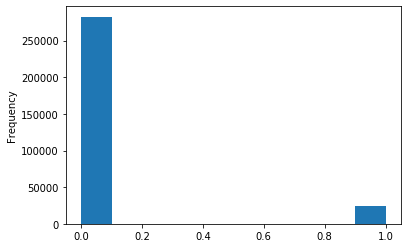

In [8]:
#Histogram target feature
clientData['target'].astype(int).plot.hist()

From the above histogram, I can see that there is a significant imbalance between the number of clients who defaulted and the number of clients who paid on time.

This is useful because when I want to evaluate my model, I can avoid using the 'accuracy score' measure since the result will not be credible and use the 'ROC-AUC' measure instead (better at handling data imbalances).

#### Histogram all numeric features

In [9]:
def histPlotAll(df):
    
    #Select numeric features
    df = df.select_dtypes(include = [np.number])
    
    #Compute layout grid size
    data_cols = len(df.columns)
    unit_size = 5
    layout_cols = 4
    layout_rows = int(data_cols / layout_cols + layout_cols)
    
    #Make plots
    df.hist(figsize = (layout_cols * unit_size, layout_rows * unit_size), layout = (layout_rows, layout_cols))
    
    #Show plot
    plt.show()

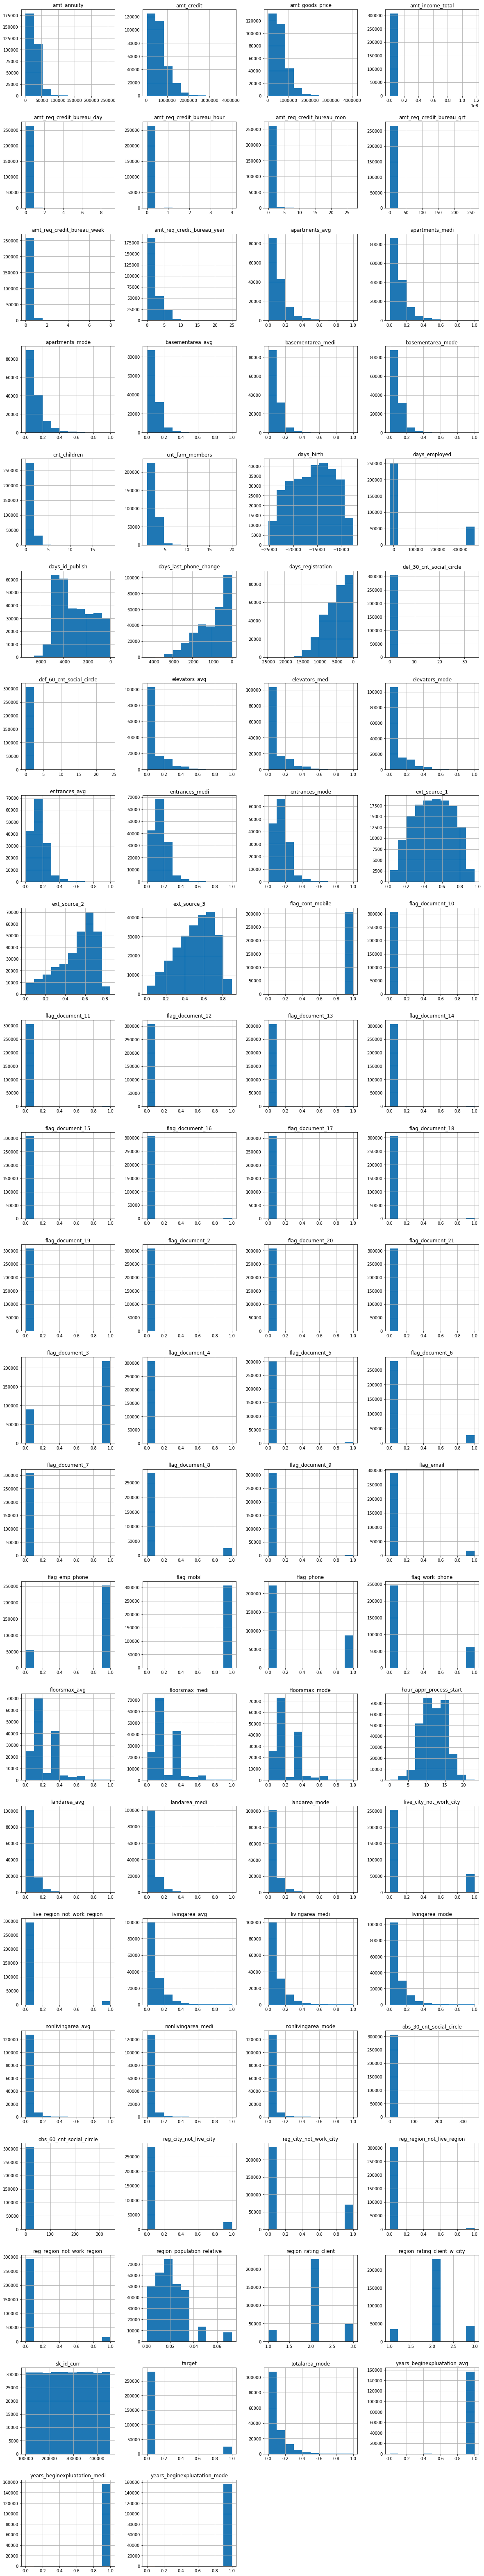

In [10]:
histPlotAll(clientData)

From the above histograms, it can be seen that for the days employed feature, there are some outliers since the days worked cannot be 250,000 (over 600 years) so it needs to be handled in case the feature was chosen for modeling.

Also, the days birth feature has negative days (but this is explained in the appendix of the dataset that the days birth is counted backwards from the day the loan was requested).

#### Boxplot all numeric features

In [11]:
def boxPlotAll(df):
    
    #Select numeric features
    df = df.select_dtypes(include = [np.number])
    
    #Compute layout grid size
    data_cols = len(df.columns)
    unit_size = 5
    layout_cols = 4
    layout_rows = int(data_cols / layout_cols + layout_cols)
    
    #Make plots
    df.plot(kind = 'box', subplots = True, figsize = (layout_cols * unit_size, layout_rows * unit_size), \
                                            layout = (layout_rows, layout_cols))
    
    #Show plot
    plt.show()

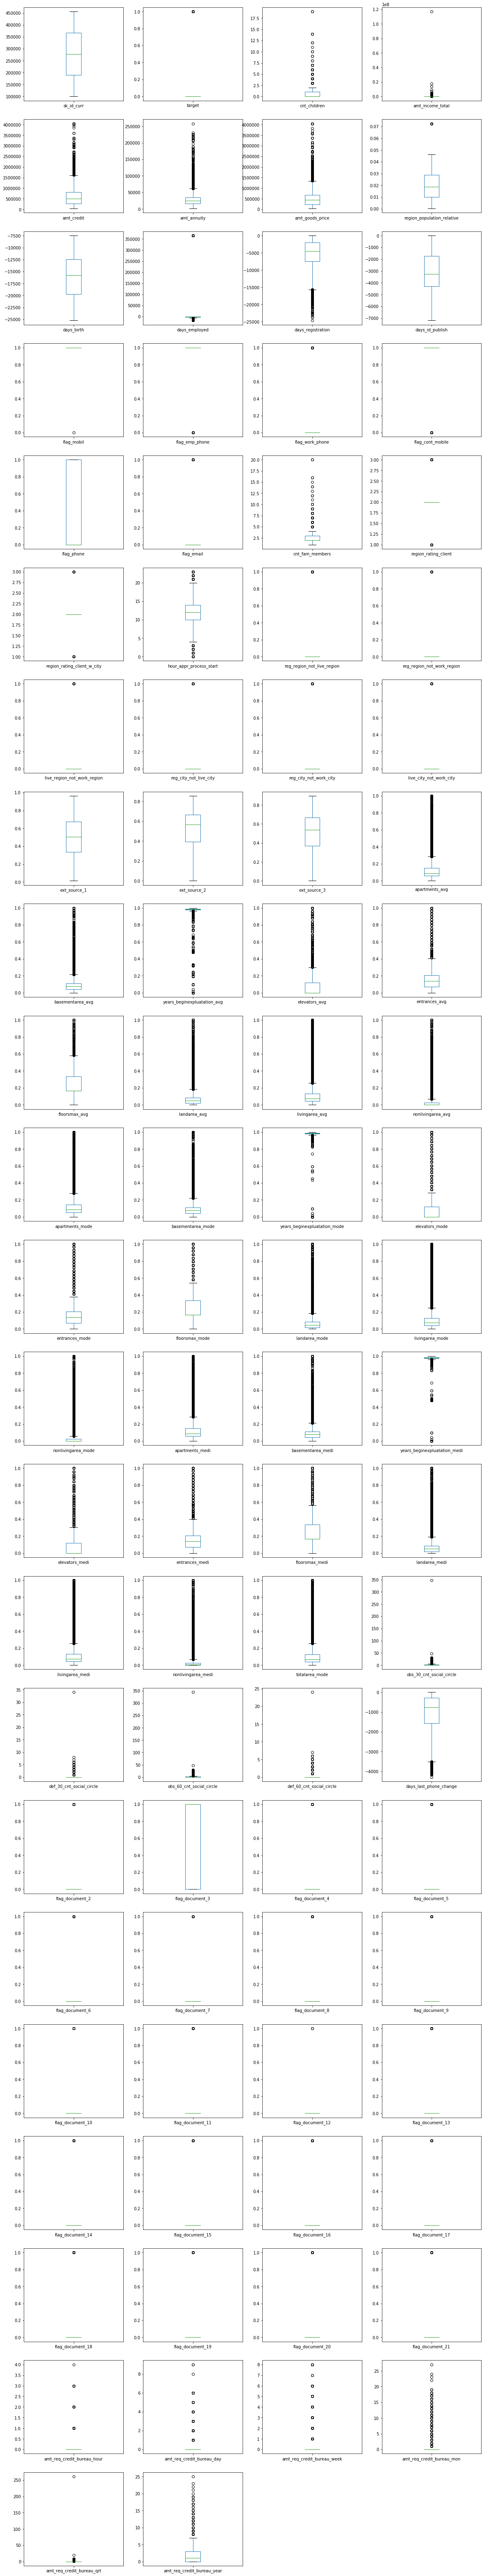

In [12]:
boxPlotAll(clientData)

The scatter plots help us identify the outliers in the features.

#### Check feature types

In [13]:
clientData.dtypes.value_counts()

float64    49
int64      41
object     15
dtype: int64

From the data types, there are 15 object features thus they will need to be handled before building the models.

#### Get number of unique classes for each object type

In [14]:
clientData.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

name_contract_type             2
code_gender                    3
flag_own_car                   2
flag_own_realty                2
name_type_suite                7
name_income_type               8
name_education_type            5
name_family_status             6
name_housing_type              6
occupation_type               18
weekday_appr_process_start     7
organization_type             58
housetype_mode                 3
wallsmaterial_mode             7
emergencystate_mode            2
dtype: int64

The features above are the categorical variables in the dataset. To be able to use them in my model, I will quantify them by using encoding techniques (one hot enconding & label encoding).

## Handling Categorical Variables (encoding)

#### Label encoding

In [15]:
#Import package
from sklearn.preprocessing import LabelEncoder

#Create a label encoder object
le = LabelEncoder()
le_count = 0

#Iterate through the columns
for col in clientData:
    if clientData[col].dtype == 'object':
        
        #If 2 or fewer unique categories
        if len(list(clientData[col].unique())) <= 2:
            
            #Train on the training data
            le.fit(clientData[col])
            
            #Transform training data
            clientData[col] = le.transform(clientData[col])
            
            #Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


#### One-hot encoding

In [16]:
#One-hot encoding of categorical variables
clientData = pd.get_dummies(clientData)

print('Features shape after enconding categorical variables: ', clientData.shape)

Features shape after enconding categorical variables:  (307511, 223)


## Exploratory Data Analysis II

#### Check correlation with target for feature selection

In [17]:
#Find correlations with the target and sort
correlations = clientData.corr()['target'].sort_values()

#Display correlations
print('Most Positive Correlations:\n', correlations.tail(5))
print('\nMost Negative Correlations:\n', correlations.head(5))

Most Positive Correlations:
 name_income_type_Working       0.057481
region_rating_client           0.058899
region_rating_client_w_city    0.060893
days_birth                     0.078239
target                         1.000000
Name: target, dtype: float64

Most Negative Correlations:
 ext_source_3                           -0.178919
ext_source_2                           -0.160472
ext_source_1                           -0.155317
name_education_type_Higher education   -0.056593
code_gender_F                          -0.054704
Name: target, dtype: float64


From the above correlation table, I observe that that the most positive correlation is with the "days birth" feature (0.078). The values, on the other hand, for days birth are negative (as can be seen in the histograms plotted above), therefore its interpretation can be misleading. To handle that, I will take the absolute value of the feature and then the correlation is expected to become negative (inline with expectations).

I also observe a negative correlation between the target feature and the ext_source_1, ext_source_2 and ext_source_3. This negative relationship means that the higher those variables are, the less likely the client will default.

### Days Birth Feature

#### Effect of the age on loan default (abs)

In [18]:
#Find the correlation of the positive days since birth and target
clientData['days_birth'] = abs(clientData['days_birth'])
clientData['days_birth'].corr(clientData['target'])

-0.07823930830982745

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time.

#### Histogram age feature

Text(0, 0.5, 'Count')

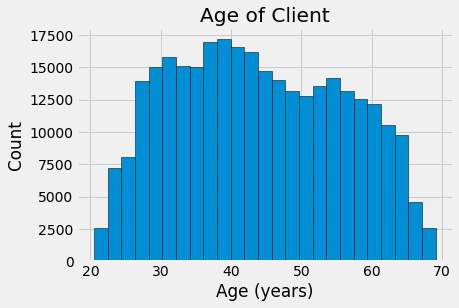

In [19]:
#Plot the distribution of ages in years
plt.style.use('fivethirtyeight')
plt.hist(clientData['days_birth'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

From the above histogram, it is observed that there are no outliers for the days birth feature.

#### Kernel Density Plot Age and Target feature

<Figure size 576x576 with 0 Axes>

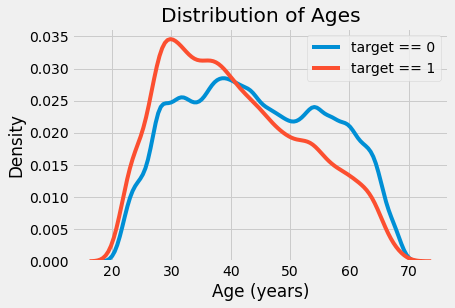

<Figure size 576x576 with 0 Axes>

In [20]:
#KDE plot of loans that were repaid on time
sns.kdeplot(clientData.loc[clientData['target'] == 0, 'days_birth'] / 365, label = 'target == 0')

#KDE plot of loans which were not repaid on time
sns.kdeplot(clientData.loc[clientData['target'] == 1, 'days_birth'] / 365, label = 'target == 1')

#Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

#Plot dimensions
plt.figure(figsize = (8, 8))

From the above kernel density estimation, it can be observed that for target == 1 (default), it is more skewed towards the younger age (as expected).

#### Check probability default within age groups (bin age groups)

In [21]:
#Take age data into a separate dataframe
ageData = clientData[['target', 'days_birth']]

#Create years birth column
ageData['years_birth'] = ageData['days_birth'] / 365

#Bin the age data
ageData['years_binned'] = pd.cut(ageData['years_birth'], bins = np.linspace(20, 70, num = 11))

#Display head
ageData.head()

,target,days_birth,years_birth,years_binned
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"


In [22]:
#Group by the bin and calculate averages
ageGroups = ageData.groupby('years_binned').mean()
ageGroups

,target,days_birth,years_birth
years_binned,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

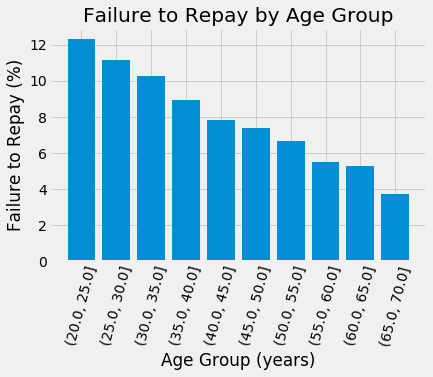

In [23]:
#Graph the age bins and the average of the target as a bar plot
plt.bar(ageGroups.index.astype(str), 100 * ageGroups['target'])

#Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

It can be clearly seen that the younger age group is more likely to default. This can be used by banks in order to be able to identify the clients that have a higher potential to default.

### External Source Features

#### Create new dataset taking only features of interest

In [24]:
#Create new dataset with ext_source features and days_birth
externalData = clientData[['target', 'ext_source_1', 'ext_source_2', 'ext_source_3', 'days_birth']]

#Get correlations
externalData_corrs = externalData.corr()
externalData_corrs

,target,ext_source_1,ext_source_2,ext_source_3,days_birth
target,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
ext_source_1,-0.155317,1.000000,0.213982,0.186846,0.600610
ext_source_2,-0.160472,0.213982,1.000000,0.109167,0.091996
ext_source_3,-0.178919,0.186846,0.109167,1.000000,0.205478
days_birth,-0.078239,0.600610,0.091996,0.205478,1.000000


From the correlation table, days birth and ext_source_1 are highly correlated (0.60). This can imply that the ext_source_1 scoring of a client may have the days birth of the client as a feature.

#### Plot Correlation Matrix

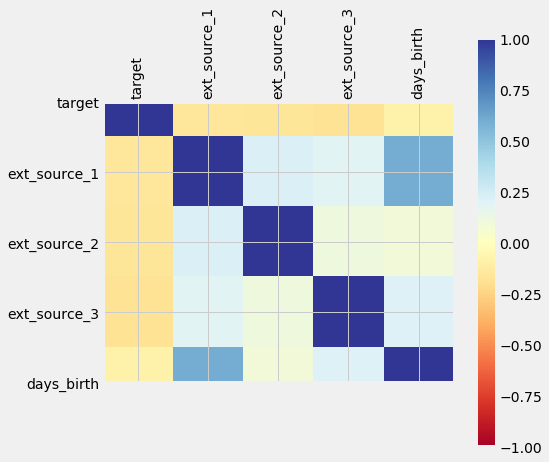

In [25]:
#Define a function for correlation matrix
def correlationMatrix(df):
    
    #Take only numeric features and setup the plot
    columns = df.select_dtypes(include=['float64','int64']).columns
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none',cmap='RdYlBu')
    fig.colorbar(cax)
    
    #Set up the labels and dimensions of the plot
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    ax.set_xticklabels(columns, rotation = 90)
    ax.set_yticklabels(columns)
    
    #Display plot
    plt.show()
    

#Show correlation matrix
correlationMatrix(externalData)

From the correlation matrix heatmap, we can see that all external sources exhibit a negative linear relationship with the target feature. This implies, as those features increase, the probability of default will decrease.

There also exists a positive relationship between days_birth and ext_source_1 which may indicate that the ext_source_1 feature takes the client's age into consideration for the rating (as mentioned previously).

#### Kernel Density Plot Age and Target feature

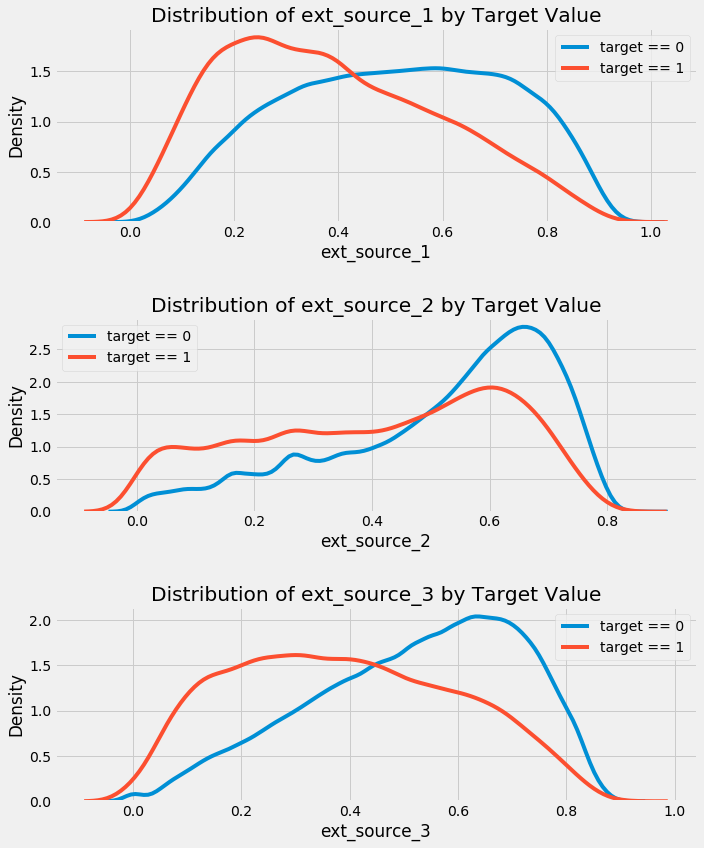

In [26]:
#Define size of figure
plt.figure(figsize = (10, 12))

#Iterate through the sources
for i, source in enumerate(['ext_source_1', 'ext_source_2', 'ext_source_3']):
    
    #Create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    
    #Plot repaid loans
    sns.kdeplot(clientData.loc[clientData['target'] == 0, source], label = 'target == 0')
    
    #Plot loans that were not repaid
    sns.kdeplot(clientData.loc[clientData['target'] == 1, source], label = 'target == 1')
    
    #Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

From the above kernel density plots, the biggest and most significant difference between the values of the target lie in ext_source_3.

#### Pairs plot between selected features

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

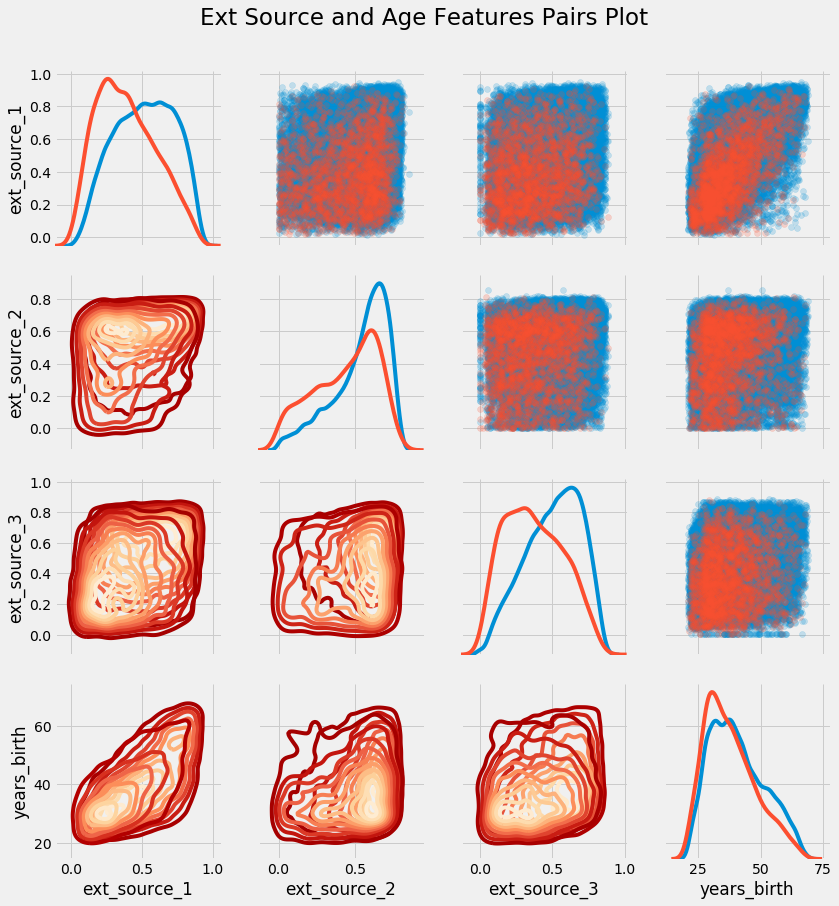

In [27]:
#Copy the data for plotting
plotData = externalData.drop(columns = ['days_birth']).copy()

#Add in the age of the client in years
plotData['years_birth'] = ageData['years_birth']

#Drop na values and limit to first 100000 rows
plotData = plotData.dropna().loc[:100000, :]

#Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy = (.2, .8), xycoords = ax.transAxes,
                size = 20)

#Create the pairgrid object
grid = sns.PairGrid(data = plotData, size = 3, diag_sharey = False,
                    hue = 'target', 
                    vars = [x for x in list(plotData.columns) if x != 'target'])

#Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

#Diagonal is a histogram
grid.map_diag(sns.kdeplot)

#Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 23, y = 1.05)

From the above pairplot, we can see somehow of a positive relationship between years birth and ext source 1 (this proves the previously stated point that the ext source 1 feature may include the client's age in the rating).

### EDA - Other features

#### 1. Number of children the client has

In [28]:
#Define function that plots selected feature against number of contracts and with target == 1
def plot_stats(feature, label_rotation = False, horizontal_layout = True):
    
    temp = clientData[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, 'Number of contracts': temp.values})

    #Calculate the percentage of target=1 per category value
    cat_perc = clientData[[feature, 'target']].groupby([feature],as_index = False).mean()
    cat_perc.sort_values(by = 'target', ascending = False, inplace = True)
    
    #Set the figure
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax = ax1, x = feature, y = "Number of contracts", data = df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(), rotation = 90)
    
    s = sns.barplot(ax = ax2, x = feature, y = 'target', order = cat_perc[feature], data = cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation = 90)
    plt.ylabel('% of target == 1 [default]', fontsize = 10)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 10)

    plt.show()

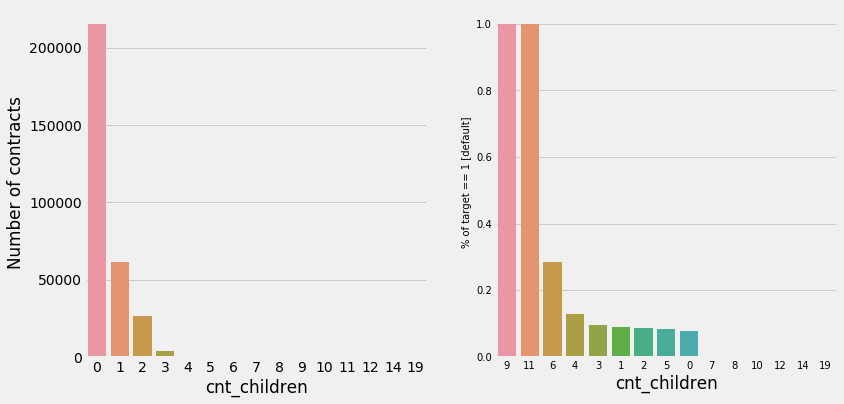

In [29]:
plot_stats('cnt_children')

Most of the clients taking a loan have no children. The number of loans associated with the clients with one children are 4 times smaller, the number of loans associated with the clients with two children are 8 times smaller; clients with 3, 4 or more children are much more rare.

As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children).

As for clients with 9 or 11 children, the percent of loans not repaid is 100%.

#### 2. Number of family members living in household

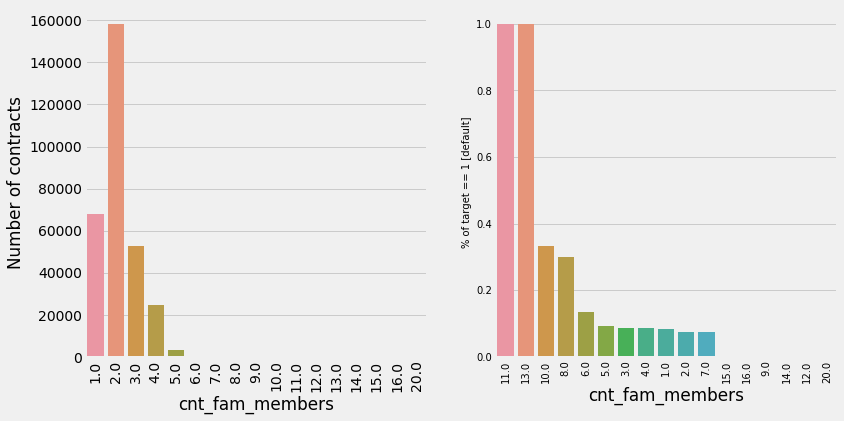

In [30]:
plot_stats('cnt_fam_members', True)

Clients with family members of 2 are most numerous, followed by 1 (single person), 3 (families with one child) and 4.

Clients with family size of 11 and 13 have 100% not repayment rate. Other families with 10 or 8 members have percents of not repayment of loans over 30%. Families with 6 or less members have repayment rates close to the 10% average.

#### 3. Days Employed

In [31]:
#Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize = (10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(clientData[feature].dropna(),color = color, kde = True, bins=100)
    plt.show() 

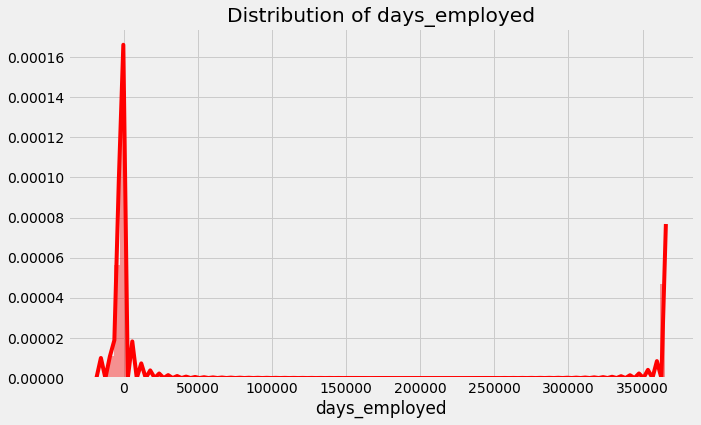

In [32]:
#Get dist plot days employed
plot_distribution('days_employed','red')

The negative values means days since employed and most probably these negative values means unemployed. It is not clear what will be the meaning of the very large numbers at the far end (it is not realistic such a large set of people employed more than 100 years ~ as seen before).

#### 4. Amount Credit

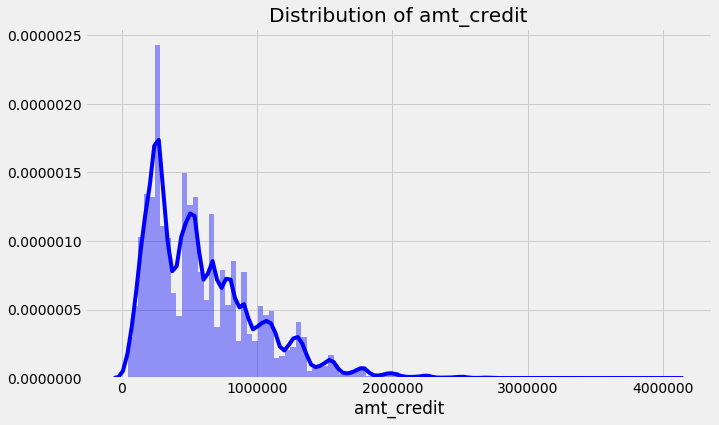

In [33]:
plot_distribution('amt_credit','blue')

The credit amount of the loan is mostly concentrated at 500,000 as can be seen in the distribution plot above.

## Data Cleaning II

#### Imputate the features with column mean

In [34]:
#Imputate null values with column's resepective mean
clientData = clientData.fillna(clientData.mean())

#Display head
clientData.head()

,sk_id_curr,target,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,housetype_mode_terraced house,wallsmaterial_mode_Block,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,emergencystate_mode_No,emergencystate_mode_Yes
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


## Build Logistic Regression

In [35]:
#Import packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Define inputs and target variables
X = clientData.drop(['target', 'sk_id_curr'], axis = 1)
y = clientData['target']

#Rescale inputs
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

#Split train/test
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

#Get train and test shape
print('Train set shape: ', X_train.shape)
print('Test set shape: ', X_test.shape)

Train set shape:  (206032, 221)
Test set shape:  (101479, 221)


#### Build the Logistic Regression Model

In [36]:
#Import package
from sklearn.linear_model import LogisticRegression

#Build and fit model
model = LogisticRegression(C = 0.0001, max_iter = 100)
model.fit(X_train, y_train)

#Get predictions (yhat)
predictions = model.predict(X_test)

Now for the evaluation of the model, I will be using the ROC-AUC method since this method handles imbalanced datasets really well comparing to other metrics.

#### ROC-AUC Evaluation

In [37]:
#Import package
from sklearn.metrics import roc_curve, auc, roc_auc_score

#Define function to plot ROC curve along with AUC score
def plotRocAuc(model, X, y):
    
    probabilities = model.predict_proba(X)
    probabilities = probabilities[:, 1] #keep probability as first column
    
    #Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, probabilities)
    
    #Plot dumb model line
    plt.plot([0,1], [0,1], linestyle = '--')
    
    #Plot model line
    plt.plot(fpr, tpr, marker = '.')
    plt.title('ROC Curve for default')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.text(0.75, 0.25, 'AUC ' + str(round(roc_auc_score(y, probabilities), 3)))
    plt.show()

#### Check model

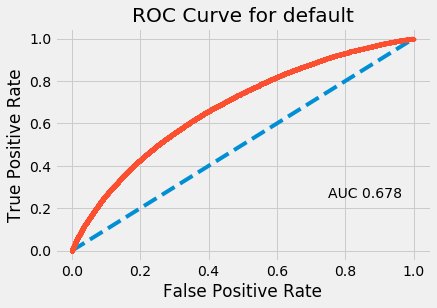

In [38]:
#Check model using train set
plotRocAuc(model, X_train, y_train)

#### Evaluate Model

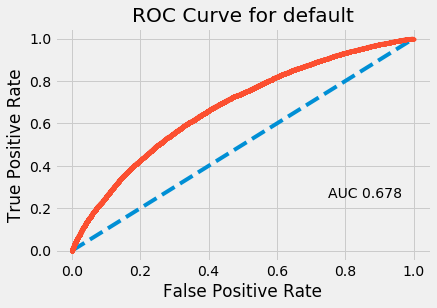

In [39]:
#Evaluate model using test set
plotRocAuc(model, X_test, y_test)

After evaluating the model, the AUC score is 0.678 which means that our model is acceptable but there is always a room for improvement.

The next steps would be to do some feature engineering, feature selection and build a random forest classifier to see if it will perform better or worse than this logistic regression.

## Automated Feature Engineering

_In this section, I will use the featuretools package in order to automate the feature engineering process. For this, I will import a new dataset "bureauData" that contains application data from previous loans that the client got from other institutions and that were reported to the credit bureau. I will also import the client dataset again._

#### Import featuretools package and datasets

In [40]:
#Import featuretools package
import featuretools as ft

#Import datasets (sort by IDs)
bureauData = pd.read_csv('/Users/user/Desktop/Risk/bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True)
clientData_new = pd.read_csv('/Users/user/Desktop/Risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True)

#### Create an empty entityset

In [41]:
#Entity set with id applications
es = ft.EntitySet(id = 'clients')

#### Define the tables inside the entity set

In [42]:
#Entities with unique index
es = es.entity_from_dataframe(entity_id = 'clientData_new', dataframe = clientData_new, index = 'SK_ID_CURR')
es = es.entity_from_dataframe(entity_id = 'bureauData', dataframe = bureauData, index = 'SK_ID_BUREAU')

#### Create relationships between tables

In [43]:
#Get information on parent and child tables
print('Parent: clientData_new, Parent Variable: SK_ID_CURR\n\n', clientData_new.iloc[:, 0:5].head())
print('\nChild: bureauData, Child Variable: SK_ID_CURR\n\n', bureauData.iloc[10:30, :4].head())

Parent: clientData_new, Parent Variable: SK_ID_CURR

    SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR
0      100002       1         Cash loans           M            N
1      100003       0         Cash loans           F            N
2      100004       0    Revolving loans           M            Y
3      100006       0         Cash loans           F            N
4      100007       0         Cash loans           M            N

Child: bureauData, Child Variable: SK_ID_CURR

     SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY
10      100002       6158905        Closed      currency 1
11      100002       6158906        Closed      currency 1
12      100002       6158907        Closed      currency 1
13      100002       6158908        Closed      currency 1
14      100002       6158909        Active      currency 1


In [44]:
#Define relationships between clientData_trim and bureauData
r_clientData_bureau = ft.Relationship(es['clientData_new']['SK_ID_CURR'], es['bureauData']['SK_ID_CURR'])

In [45]:
#Add in the defined relationships
es = es.add_relationships([r_clientData_bureau])

#Print out the EntitySet
es

Entityset: clients
  Entities:
    clientData_new [Rows: 307511, Columns: 122]
    bureauData [Rows: 1716428, Columns: 17]
  Relationships:
    bureauData.SK_ID_CURR -> clientData_new.SK_ID_CURR

#### DFS with selected agg primitives

In [46]:
#Specify the aggregation primitives of my choice
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'clientData_new',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 173 features
Elapsed: 04:57 | Progress: 100%|██████████


#### Display dataset

In [47]:
#Display the dataset (with 10 columns only)
pd.options.display.max_columns = 10
feature_matrix.reset_index(inplace = True)

In [48]:
feature_matrix.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,...,MEAN(bureauData.DAYS_CREDIT_UPDATE),MEAN(bureauData.CREDIT_DAY_OVERDUE),MODE(bureauData.CREDIT_CURRENCY),MODE(bureauData.CREDIT_ACTIVE),MODE(bureauData.CREDIT_TYPE)
0,100002,1,Cash loans,M,N,...,-499.875,0.0,currency 1,Closed,Consumer credit
1,100003,0,Cash loans,F,N,...,-816.000,0.0,currency 1,Closed,Consumer credit
2,100004,0,Revolving loans,M,Y,...,-532.000,0.0,currency 1,Closed,Consumer credit
3,100006,0,Cash loans,F,N,...,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,...,-783.000,0.0,currency 1,Closed,Consumer credit


## Random Forest Classifier

_Random forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes the model’s prediction. The fundamental concept of random forests is: "A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models"._

_Random Forests are a great way to verify initial hypotheses and identify what the model is learning. The advantage of kernel methods is that we are able to capture non-linear relations between variables by projecting the features into a kernel space._

_I will also be using the random forest classifier for feature selection because the tree based strategies used by random forests naturally ranks by how well they improve the purity of the node. This mean decrease in impurity over all trees (the gini impurity). Nodes with the greatest decrease in impurity happen at the start of the trees, while nodes with the least decrease in impurity occur at the end of the trees. Thus, by pruning trees below a particular node, we can create a subset of the most important features._

### Initial Random Forest

#### Seperate the features from the target variable

In [49]:
features = feature_matrix.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
labels = feature_matrix['TARGET']

#### OHE on features and impute nulls with features mean

In [50]:
#Encoding catagorical data
features = pd.get_dummies(features)

#Impute nulls with feature mean
features = features.fillna(features.mean())

#### Build the initial Random Forest

In [51]:
#Train/test split dataset
train, test, train_labels, test_labels = train_test_split(features, labels, test_size = 0.33, random_state = 66)

#Import package
from sklearn.ensemble import RandomForestClassifier

#Build model and fit training set
rfc = RandomForestClassifier()
rfc.fit(train, train_labels)

#Get predictions
rfc_predict = rfc.predict(test)

#### Understand the trees

In [52]:
#Initialize empty nodes and depths sets
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in rfc.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 31874
Average maximum depth 61


#### Evaluate the model

In [53]:
#Import packages
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

#Get cross validation scores
rfc_cv_score = cross_val_score(rfc, features, labels, cv = 5, scoring = 'roc_auc')

#Print results
print("=== Classification Report ===")
print(classification_report(test_labels, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     93291
           1       0.38      0.01      0.02      8188

    accuracy                           0.92    101479
   macro avg       0.65      0.50      0.49    101479
weighted avg       0.88      0.92      0.88    101479



=== All AUC Scores ===
[0.62722569 0.63443244 0.6282916  0.63156684 0.62953535]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6302103851423203


Precision is the proportion of predictions of that class that are true. So 92% of the predictions for target == 0 are actually of the predicted class, and 8% are actually of the opposite class. Also, 38% of the predictions for target == 1 are actually of the predicted class and 72% are of the other class.


Recall is the proportion of the true positives that are identified as such. This means that your model is correctly identifying 100% of the class 0s but 1% of class 1.


I will evaluate my model based on the mean AUC score of 0.63 (since it is best metric at handling imbalanced data). My aim now is to try to improve this score through feature selection and hyperparameter tuning using RandomizedSearch.

#### Visualize ROC-AUC score

In [54]:
#Training predictions (to demonstrate overfitting)
train_rf_predictions = rfc.predict(train)
train_rf_probs = rfc.predict_proba(train)[:, 1]

#Testing predictions (to determine performance)
rf_predictions = rfc.predict(test)
rf_probs = rfc.predict_proba(test)[:, 1]

Recall Baseline: 1.0 Test: 0.01 Train: 0.82
Precision Baseline: 0.08 Test: 0.38 Train: 1.0
Roc Baseline: 0.5 Test: 0.63 Train: 1.0


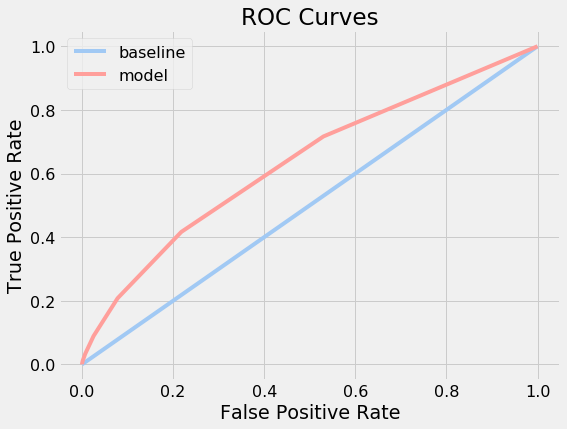

In [55]:
#Import packages
from sklearn.metrics import precision_score, recall_score

#Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    #Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    #Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();


#Plot graph
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

### Feature Selection

#### Get the most important features and remove the features with 0 importance

In [56]:
#Get feature importance (multiply by 3000 to have them on a bigger scale)
feature_importances = rfc.feature_importances_ * 3000
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

,feature,importance
28,EXT_SOURCE_2,104.812743
29,EXT_SOURCE_3,82.313686
6,DAYS_BIRTH,61.491339
9,DAYS_ID_PUBLISH,58.068624
8,DAYS_REGISTRATION,57.274746


In [57]:
#Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))

There are 13 features with 0.0 importance


In [58]:
#Remove zero importance features
features = features.drop(columns = zero_features)

print('Dataset shape: ', features.shape)

Dataset shape:  (307511, 297)


#### Visualize most important features and plot cumulative importance graph

In [59]:
def plot_feature_importances(df, threshold = 0.7):
    
    plt.rcParams['font.size'] = 18
    
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    #Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    #Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    #Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    #Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

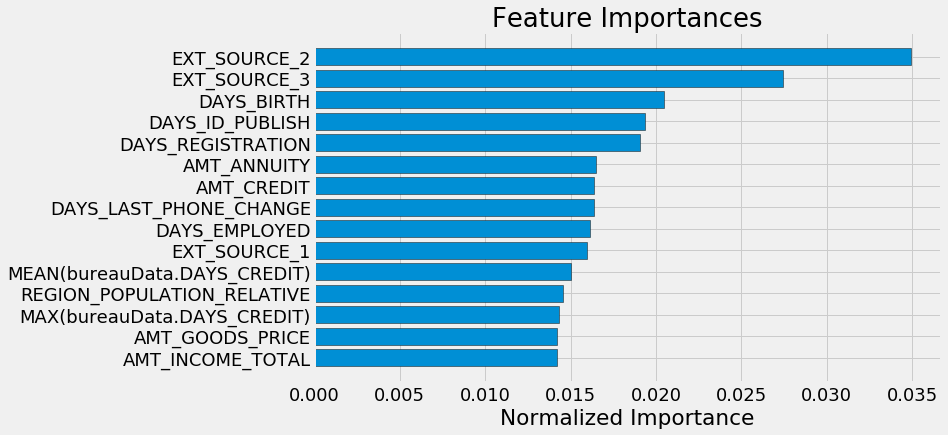

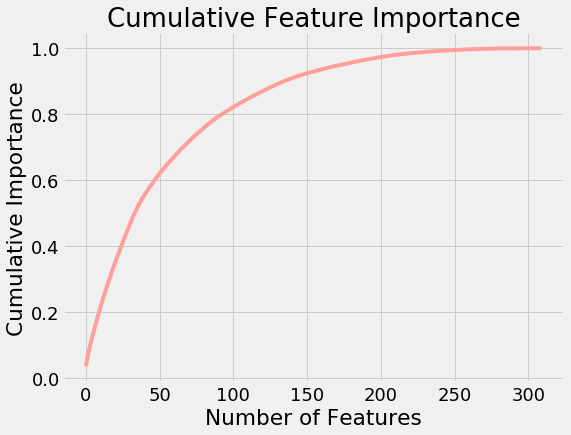

67 features required for 0.70 of cumulative importance


In [60]:
#Plot the graphs
norm_feature_importances = plot_feature_importances(feature_importances)

From the above cumulative importance graph, I can see that at 70% cumulative the curve started to flatten (this implies that after that point, the new features in the model add little value to the model, so I will not choose them).

#### Create new dataframe containing only the features of interest (up to 70% importance)

In [61]:
#Specify the threshold
threshold = 0.70

#Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

#Create new datasets with smaller features
finalData = features[features_to_keep]

#Check data
finalData.head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,...,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,MEAN(bureauData.AMT_CREDIT_SUM_LIMIT),LANDAREA_MODE
0,0.262949,0.139376,-9461,-2120,-3648.0,...,0.025200,0.036900,0.036900,7997.141250,0.037700
1,0.622246,0.510853,-16765,-291,-1186.0,...,0.092400,0.052900,0.052900,202500.000000,0.012800
2,0.555912,0.729567,-19046,-2531,-4260.0,...,0.114231,0.088442,0.087955,0.000000,0.064958
3,0.650442,0.510853,-19005,-2437,-9833.0,...,0.114231,0.088442,0.087955,5901.475578,0.064958
4,0.322738,0.510853,-19932,-3458,-4311.0,...,0.114231,0.088442,0.087955,0.000000,0.064958


### Hyperparameter Tuning

#### Setup for hyperparameter tuning using RandomizedSearchCV

In [62]:
#Train/test split finalData
X_train2, X_test2, y_train2, y_test2 = train_test_split(finalData, labels, test_size = 0.33, random_state = 66)

#Import package
from sklearn.model_selection import RandomizedSearchCV

#Specifiy number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

#Specify max depth in forest
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)

#Create the random grid dictionary
random_grid = {
 'n_estimators': n_estimators,
 'max_depth': max_depth
 }

#Apply the RandomizedSearchCV
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid,\
                                n_iter = 100, cv = 2, verbose = 2, random_state = 42, n_jobs = -1)

#### Fit training set and get best parameters

In [63]:
#Fit the model
rfc_random.fit(X_train2, y_train2)

#Print out best parameters
print(rfc_random.best_params_)

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 125.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 469.0min finished


{'n_estimators': 200, 'max_depth': 300}


### Build model with best parameters

#### New model

In [64]:
#Fit the model
rfc = RandomForestClassifier(n_estimators = 200, max_depth = 300, max_features = 'auto')
rfc.fit(X_train2, y_train2)

#Predictions and get score
rfc_predict = rfc.predict(X_test2)
rfc_cv_score = cross_val_score(rfc, features, labels, cv = 5, scoring = 'roc_auc')

#### Evaluate new model

In [65]:
print("=== Classification Report ===")
print(classification_report(y_test2, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     93291
           1       0.65      0.00      0.01      8188

    accuracy                           0.92    101479
   macro avg       0.78      0.50      0.48    101479
weighted avg       0.90      0.92      0.88    101479



=== All AUC Scores ===
[0.72561756 0.71984199 0.71579269 0.72567594 0.71877419]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7211404744749353


The mean AUC score after feature selection and hyperparameter tuning improved from 0.63 to 0.72. This shows that with feature selection and hyperparameter tuning, we can improve the model's score of predicting classes.

#### Visualize ROC-AUC score

In [66]:
#Training predictions (to demonstrate overfitting)
train_rf_predictions2 = rfc.predict(X_train2)
train_rf_probs2 = rfc.predict_proba(X_train2)[:, 1]

#Testing predictions (to determine performance)
rf_predictions2 = rfc.predict(X_test2)
rf_probs2 = rfc.predict_proba(X_test2)[:, 1]

Recall Baseline: 1.0 Test: 0.0 Train: 1.0
Precision Baseline: 0.08 Test: 0.65 Train: 1.0
Roc Baseline: 0.5 Test: 0.71 Train: 1.0


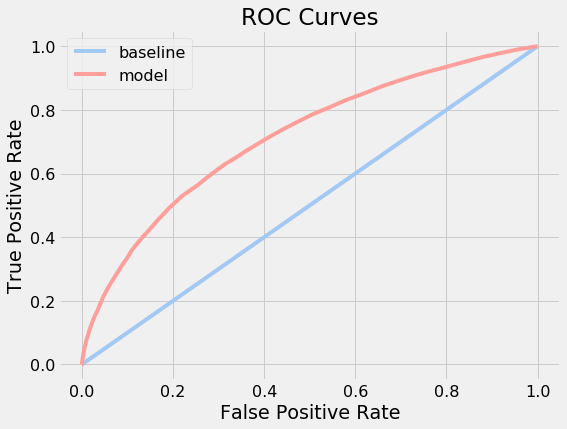

In [67]:
evaluate_model(rf_predictions2, rf_probs2, train_rf_predictions2, train_rf_probs2)

## Concluding Remarks

A logistic regression came back with an AUC score of 0.678 which means that the model is acceptable but not ideal. I wanted to try to improve the AUC score, so I went on to do some feature engineering and feature selection using random forests. After, I built a new random forest classifier with the selected features and used RandomizedSearchCV to tune hyperparameters. The overall AUC score increased to 0.721 which means that it performed better than the logistic regression (the model is better at distinguishing classes).